In [203]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jp797498e_twitter_entity_sentiment_analysis_path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Importing Libraries**

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from nltk.corpus import stopwords
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import models, layers
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout , Bidirectional

import pickle

## **Read Data**

In [204]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [207]:
path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')
data_train = pd.read_csv(os.path.join(path, 'twitter_training.csv'))
data_test = pd.read_csv(os.path.join(path, 'twitter_validation.csv'))

In [208]:
data_train.columns = ['id', 'entity', 'sentiment', 'text']
data_test.columns = ['id', 'entity', 'sentiment', 'text']

In [209]:
data = pd.concat([data_train, data_test])

In [210]:
data.sample()

,id,entity,sentiment,text
45582,11825,Verizon,Positive,@ davematthewsbnd @ verizon Sweet songs to lig...


In [212]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [213]:
nltk.download('stopwords', quiet=True)
stop_words_set = set(stopwords.words('english'))

In [214]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\x00-\x7F]', ' ', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = ' '.join([word for word in text.split() if word not in stop_words_set])
    return text

data['text'] = data['text'].apply(clean_text)

In [215]:
label_map = {'Positive': 1, 'Negative': 0, 'Neutral': 2, 'Irrelevant': 2}
data['sentiment'] = data['sentiment'].map(label_map)

In [216]:
X = data['text']
Y = data['sentiment']

In [217]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

In [218]:
max_words = 10000
max_len = 80

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

In [222]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.build(input_shape=(None, max_len))

In [223]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 80, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 80, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,335,875 (5.10 MB)

 Trainable params: 1,335,875 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [224]:
history = model.fit(
    x_train_pad,
    y_train,
    validation_data=(x_test_pad, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

Epoch 1/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.5646 - loss: 0.8991 - val_accuracy: 0.7859 - val_loss: 0.5352
Epoch 2/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8307 - loss: 0.4395 - val_accuracy: 0.8276 - val_loss: 0.4373
Epoch 3/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8856 - loss: 0.2989 - val_accuracy: 0.8486 - val_loss: 0.4101
Epoch 4/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9101 - loss: 0.2324 - val_accuracy: 0.8566 - val_loss: 0.4101
Epoch 5/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9258 - loss: 0.1850 - val_accuracy: 0.8628 - val_loss: 0.4413
Epoch 6/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9365 - loss: 0.1594 - val_accuracy: 0.8625 - val_loss: 0.4819
Epoch 7/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9432 - loss: 0.1406 - val_accuracy: 0.8669 - val_loss: 0.5170
Epoch 8/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9487 - loss: 0.1240 - 

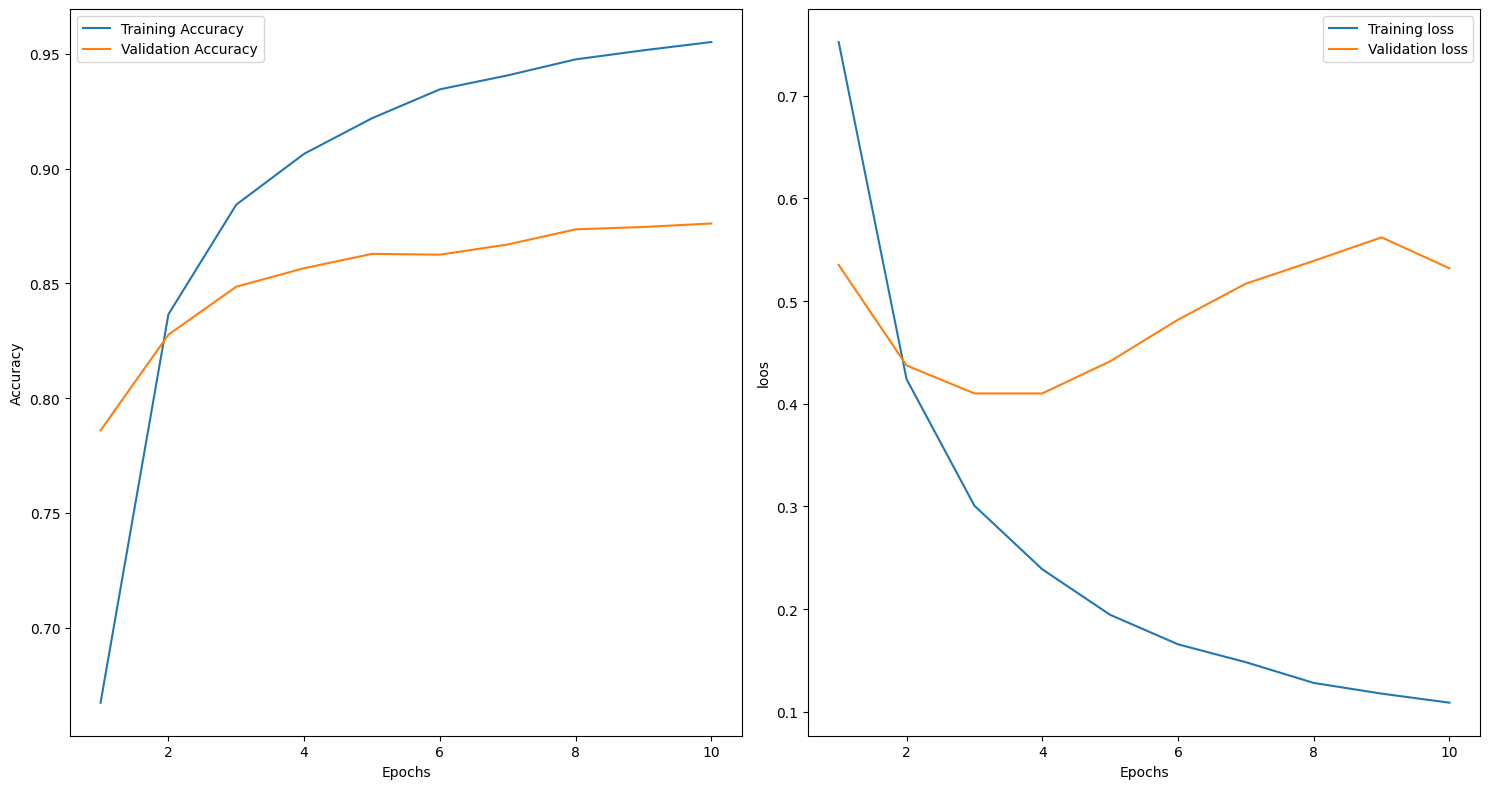

In [226]:
train_acc = history.history["accuracy"]
vaild_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
vaild_loss = history.history["val_loss"]

epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize= (15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, vaild_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, vaild_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loos')
plt.legend()

plt.tight_layout()
plt.show()

In [229]:
loss, accuracy = model.evaluate(x_test_pad, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8722 - loss: 0.5537
Test Loss: 0.5319
Test Accuracy: 87.61%


In [238]:
# جمل تجريبية
sample_texts = [
    "The food was absolutely delicious and the staff were friendly",
    "I waited for an hour and nobody came to help me",
    "The product is fine, works as expected",
    "Worst movie I have ever watched",
    "I’m so happy with my purchase, totally worth the price"
]

# تنظيف وتحويل الجمل
sample_cleaned = [clean_text(t) for t in sample_texts]  # نفس دالة التنظيف اللي استخدمتها في التدريب
sample_seq = tokenizer.texts_to_sequences(sample_cleaned)
sample_pad = pad_sequences(sample_seq, maxlen=max_len, padding='post')

# التنبؤ
predictions = model.predict(sample_pad)
predicted_labels = np.argmax(predictions, axis=1)  # رقم الكلاس

label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}

# طباعة النتائج
for i, text in enumerate(sample_texts):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {label_map[predicted_labels[i]]}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Text: The food was absolutely delicious and the staff were friendly
Predicted Sentiment: positive
--------------------------------------------------
Text: I waited for an hour and nobody came to help me
Predicted Sentiment: neutral
--------------------------------------------------
Text: The product is fine, works as expected
Predicted Sentiment: neutral
--------------------------------------------------
Text: Worst movie I have ever watched
Predicted Sentiment: negative
--------------------------------------------------
Text: I’m so happy with my purchase, totally worth the price
Predicted Sentiment: neutral
--------------------------------------------------


In [239]:
model.save('sentiment_analysis_model.h5')

In [241]:
with open("tokenizer.pkl", 'wb') as f:
    pickle.dump(tokenizer, f)